In [1]:
import pandas as pd
import yaml
import os
from os.path import join
from src.config import ROOT_DIR, RESULTS

Project Directory: /data2/mito_lineage


In [2]:
import  matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.chdir(ROOT_DIR)

In [4]:
with open("parameters/2020_09_07_Croker_mito.yaml") as f:
    config = yaml.safe_load(f)

outdir = join(config["results"], "QC")
if not os.path.exists(outdir):
    os.mkdir(outdir)
    

config


{'samples': 'parameters/2020_09_07_Croker_mito.csv',
 'results': 'data/processed/mttrace/2020_09_07',
 'figures': 'figures/mttrace/2020_09_07',
 'main': ['mt_amplicon_prelim'],
 'use_cellr_barcode': [True],
 'num_reads_filter': [200],
 'mito_character': 'MT',
 'maxBP': 16571,
 'mapq': [0],
 'ref_fa': '/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta',
 'min_cells': [100, 500, 10],
 'min_reads': [100],
 'top_cells': [0],
 'top_pos': [0],
 'cell_mt_coverage': [1, 10, 100],
 'position_bq_thresh': [0, 'Gaussian']}

In [5]:
samples = pd.read_table(config["samples"],sep=',', index_col=0)
samples = samples.dropna(axis=1)
for ind, val in samples.iterrows():
    samples.at[ind,'metrics'] = os.path.join(os.path.dirname(val['bam_f']),"metrics_summary.csv")

for ind, val in samples.iterrows():
    df = pd.read_csv(val["metrics"])
    df.index = [ind]
    df.index.name = "sample"
    if df.columns[0] in samples.columns:
        samples.loc[ind, df.columns] = df.loc[ind]
    else:
        samples = samples.merge(df, how='outer', left_index=True, right_index=True)
        
samples = samples.drop(labels=["bam_f", "metrics"], axis=1)

samples

,Estimated Number of Cells,Mean Reads per Cell,Median Genes per Cell,Number of Reads,Valid Barcodes,Sequencing Saturation,Q30 Bases in Barcode,Q30 Bases in RNA Read,Q30 Bases in RNA Read 2,Q30 Bases in UMI,Reads Mapped to Genome,Reads Mapped Confidently to Genome,Reads Mapped Confidently to Intergenic Regions,Reads Mapped Confidently to Intronic Regions,Reads Mapped Confidently to Exonic Regions,Reads Mapped Confidently to Transcriptome,Reads Mapped Antisense to Gene,Fraction Reads in Cells,Total Genes Detected,Median UMI Counts per Cell
sample,,,,,,,,,,,,,,,,,,,,
CD34_Flt3L_PolydT,"4,556","6,903",836.0,"31,451,492",93.3%,15.6%,96.1%,93.2%,81.8%,95.5%,75.9%,73.2%,6.7%,9.3%,60.0%,54.8%,3.6%,46.4%,"16,936","1,345"
CD34_Flt3L_mt,"4,122","2,765",235.0,"11,400,649",75.2%,19.1%,96.0%,94.6%,87.9%,95.4%,93.3%,84.1%,8.7%,18.0%,61.3%,31.4%,29.1%,60.2%,"15,497",270
CD34_Flt3L_mt_PolydT,"4,327","3,759",541.0,"16,269,042",92.8%,13.0%,96.3%,94.2%,82.9%,95.6%,75.9%,72.6%,4.8%,12.1%,58.3%,53.0%,3.7%,51.0%,"16,040",767
CD34_PolydT,"5,928",790,85.0,"4,685,296",93.0%,12.1%,96.3%,94.3%,83.8%,95.6%,79.6%,76.0%,7.0%,10.9%,61.1%,56.0%,3.4%,40.1%,"13,598",101
CD34_mt,"5,310",925,98.0,"4,915,481",73.3%,14.7%,96.1%,94.7%,88.4%,95.5%,93.5%,80.6%,10.0%,17.1%,57.2%,29.5%,26.9%,66.2%,"14,220",104
CD34_mt_PolydT,"4,907","2,051",300.0,"10,066,935",93.3%,12.8%,96.3%,94.2%,83.1%,95.6%,76.7%,73.2%,4.4%,12.9%,58.6%,54.4%,2.5%,47.4%,"15,136",391
PBMC_mt,"6,842",672,47.0,"4,602,443",72.8%,24.1%,96.0%,94.3%,88.0%,95.5%,92.0%,70.3%,11.1%,20.6%,43.0%,22.2%,20.0%,66.3%,"14,126",52
PBMC_mt_PolydT,"7,184","1,406",207.0,"10,104,556",90.2%,16.8%,96.0%,92.4%,80.8%,95.4%,71.3%,64.5%,5.6%,17.6%,45.0%,40.0%,3.6%,65.9%,"16,015",279


In [6]:
#for ind, val in samples.iterrows():
def fill_vals(x):
    return x.replace(',','').replace('%',"")
    
for c in samples.columns:
    if samples[c].dtype == object:
        samples[c] = samples[c].astype(str) 

        samples[c] = samples[c].apply(fill_vals)
        samples[c] = samples[c].astype(float)


In [7]:
samples["Ligand"] = samples.index.str.contains("Flt3")

def find_exp(x):
    if "mt_PolydT" in x:
        return "mt_PolydT"
    elif "mt" in x:
        return "mt"
    elif "PolydT" in x:
        return "PolydT"
    else:
        print("Experiment??")
samples["Experiment"] = list(map(lambda x: find_exp(x), samples.index.values))

In [8]:
samples

,Estimated Number of Cells,Mean Reads per Cell,Median Genes per Cell,Number of Reads,Valid Barcodes,Sequencing Saturation,Q30 Bases in Barcode,Q30 Bases in RNA Read,Q30 Bases in RNA Read 2,Q30 Bases in UMI,...,Reads Mapped Confidently to Intergenic Regions,Reads Mapped Confidently to Intronic Regions,Reads Mapped Confidently to Exonic Regions,Reads Mapped Confidently to Transcriptome,Reads Mapped Antisense to Gene,Fraction Reads in Cells,Total Genes Detected,Median UMI Counts per Cell,Ligand,Experiment
sample,,,,,,,,,,,,,,,,,,,,,
CD34_Flt3L_PolydT,4556.0,6903.0,836.0,31451492.0,93.3,15.6,96.1,93.2,81.8,95.5,...,6.7,9.3,60.0,54.8,3.6,46.4,16936.0,1345.0,True,PolydT
CD34_Flt3L_mt,4122.0,2765.0,235.0,11400649.0,75.2,19.1,96.0,94.6,87.9,95.4,...,8.7,18.0,61.3,31.4,29.1,60.2,15497.0,270.0,True,mt
CD34_Flt3L_mt_PolydT,4327.0,3759.0,541.0,16269042.0,92.8,13.0,96.3,94.2,82.9,95.6,...,4.8,12.1,58.3,53.0,3.7,51.0,16040.0,767.0,True,mt_PolydT
CD34_PolydT,5928.0,790.0,85.0,4685296.0,93.0,12.1,96.3,94.3,83.8,95.6,...,7.0,10.9,61.1,56.0,3.4,40.1,13598.0,101.0,False,PolydT
CD34_mt,5310.0,925.0,98.0,4915481.0,73.3,14.7,96.1,94.7,88.4,95.5,...,10.0,17.1,57.2,29.5,26.9,66.2,14220.0,104.0,False,mt
CD34_mt_PolydT,4907.0,2051.0,300.0,10066935.0,93.3,12.8,96.3,94.2,83.1,95.6,...,4.4,12.9,58.6,54.4,2.5,47.4,15136.0,391.0,False,mt_PolydT
PBMC_mt,6842.0,672.0,47.0,4602443.0,72.8,24.1,96.0,94.3,88.0,95.5,...,11.1,20.6,43.0,22.2,20.0,66.3,14126.0,52.0,False,mt
PBMC_mt_PolydT,7184.0,1406.0,207.0,10104556.0,90.2,16.8,96.0,92.4,80.8,95.4,...,5.6,17.6,45.0,40.0,3.6,65.9,16015.0,279.0,False,mt_PolydT


In [9]:
import matplotlib

In [10]:
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels


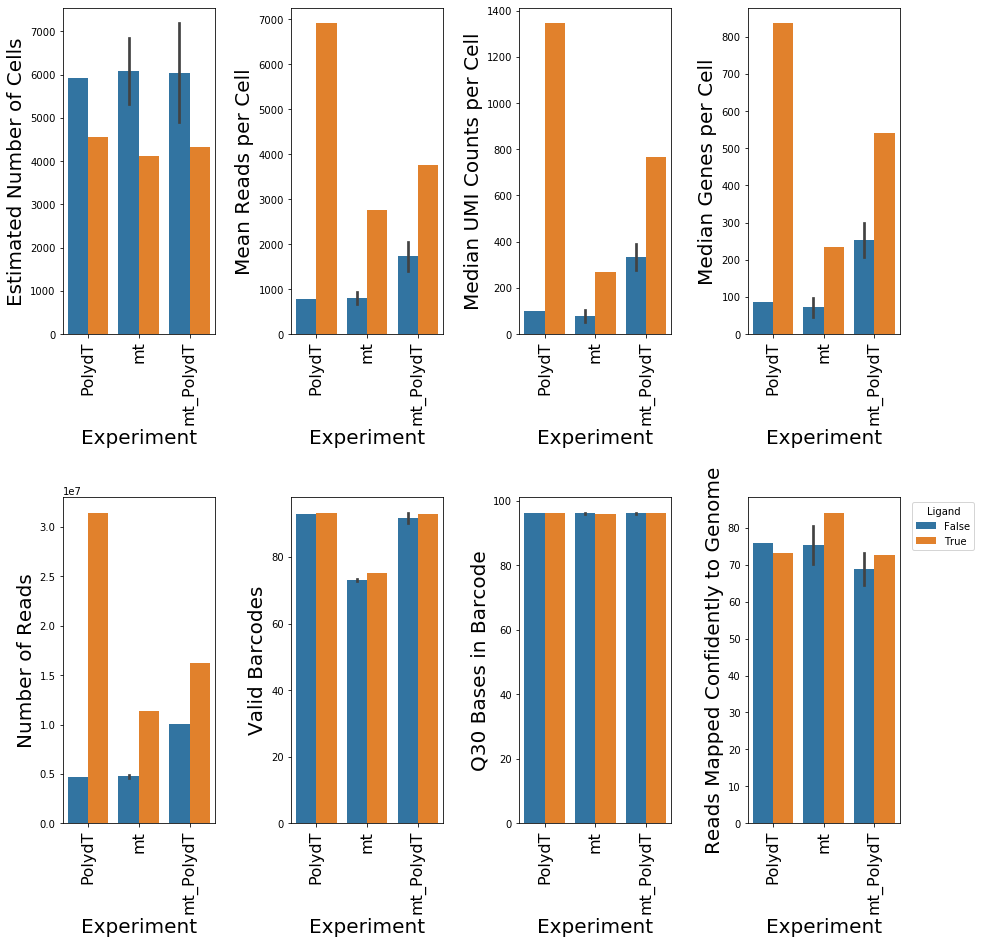

In [27]:
%matplotlib inline

cols = ["Estimated Number of Cells", 
        "Mean Reads per Cell", 
        'Median UMI Counts per Cell',
        "Median Genes per Cell", 
        "Number of Reads", 
        "Valid Barcodes", 
        "Q30 Bases in Barcode", 
        "Reads Mapped Confidently to Genome"]

f, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))
for ind, c in enumerate(cols):
    curr_ax = ax.flatten()[ind]
    sns.barplot(y=c,x="Experiment", hue="Ligand", data=samples,ax=curr_ax)
    if not ind == len(cols)-1:
        curr_ax.get_legend().remove()
    #plt.xticks(fontsize=20)
    curr_ax.tick_params(axis='x', labelsize=16) 
    curr_ax.set_xticklabels(curr_ax.get_xticklabels(),rotation=90)
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), title="Ligand", loc='upper left')
plt.savefig(join(outdir, "QC.png"))

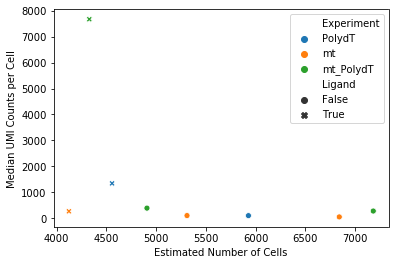

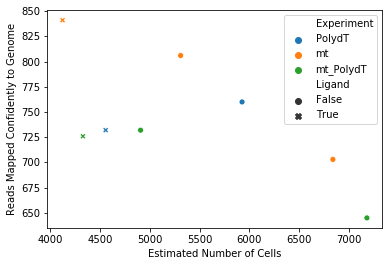

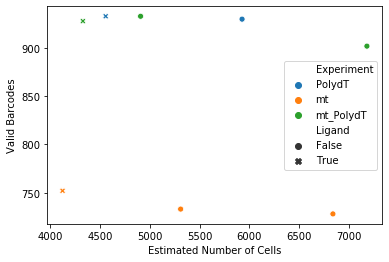

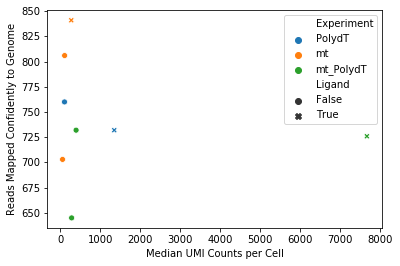

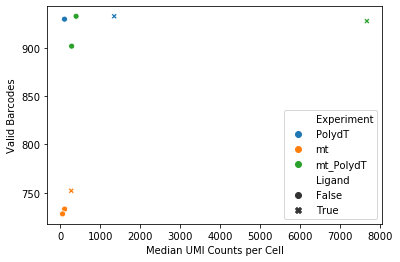

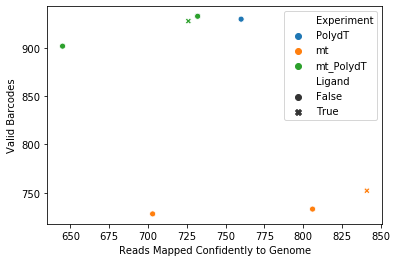

In [174]:
cols = ["Estimated Number of Cells", 
        "Mean Reads per Cell", 
        'Median UMI Counts per Cell',
        "Median Genes per Cell", 
        "Number of Reads", 
        "Valid Barcodes", 
        "Q30 Bases in Barcode", 
        "Reads Mapped Confidently to Genome"]

cols = ["Estimated Number of Cells", 
        'Median UMI Counts per Cell',
        "Reads Mapped Confidently to Genome",
        "Valid Barcodes"]


for c in range(len(cols)-1):
    for c2 in range(c+1, len(cols)):
        plt.figure()
        sns.scatterplot(data=samples, x=cols[c], y=cols[c2],
                        hue='Experiment',
                        style='Ligand') #, size=0.5)

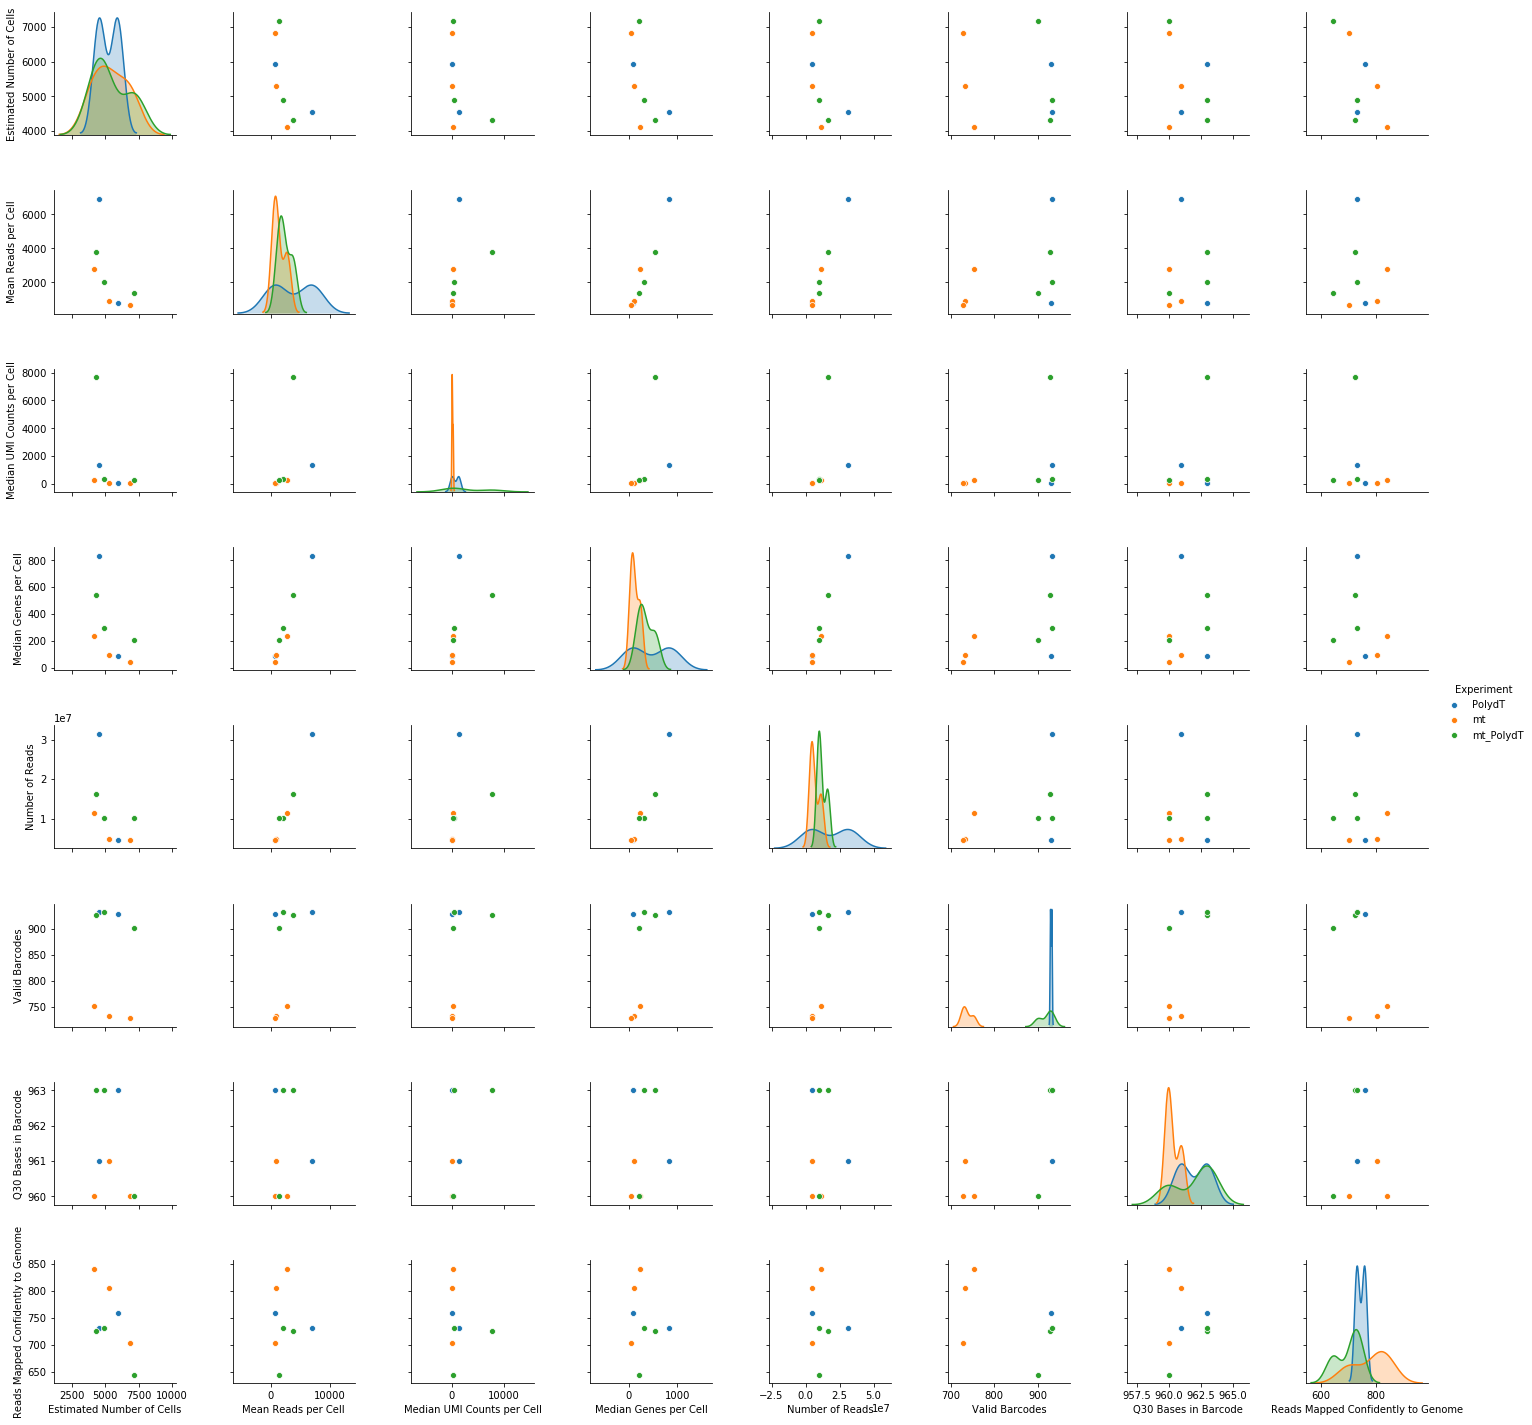

In [154]:
%matplotlib inline
sns.pairplot(samples,hue="Experiment",vars=["Estimated Number of Cells", 
                                           "Mean Reads per Cell", 
                                           'Median UMI Counts per Cell',
                                           "Median Genes per Cell", 
                                           "Number of Reads", 
                                           "Valid Barcodes", 
                                           "Q30 Bases in Barcode", 
                                           "Reads Mapped Confidently to Genome"])
    

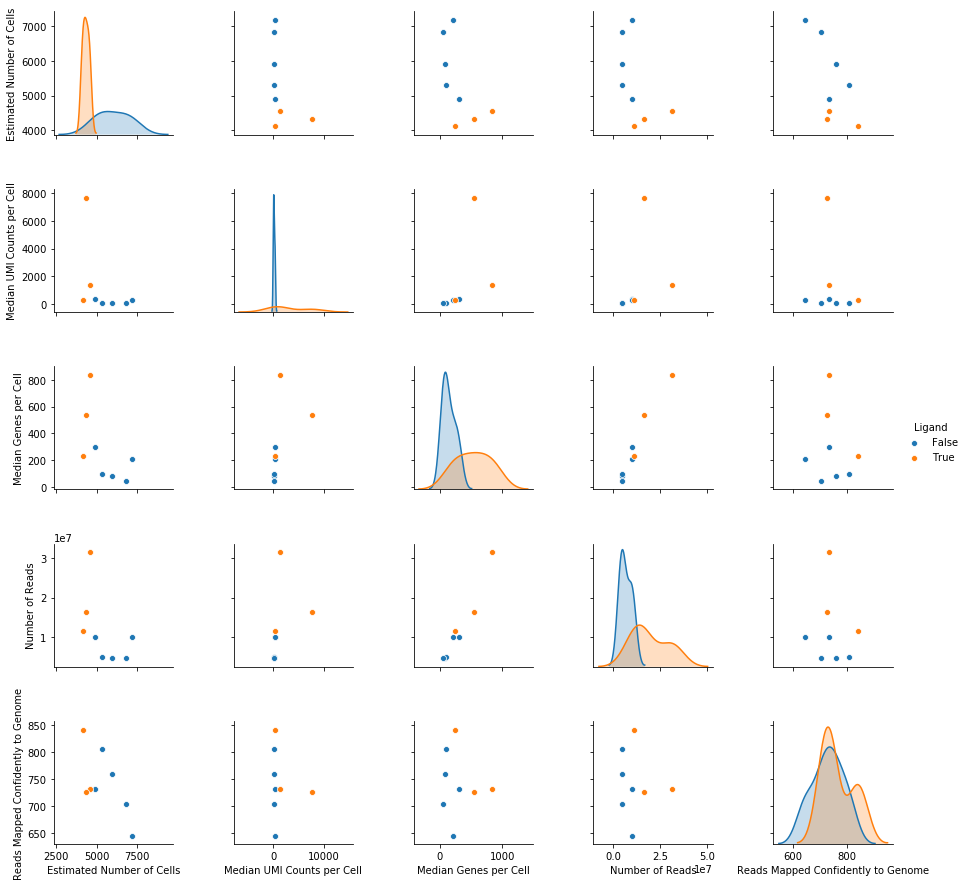

In [155]:
%matplotlib inline
sns.pairplot(samples,hue="Ligand",vars=["Estimated Number of Cells", 
                                           'Median UMI Counts per Cell',
                                           "Median Genes per Cell", 
                                           "Number of Reads", 
                                           "Reads Mapped Confidently to Genome"])
    

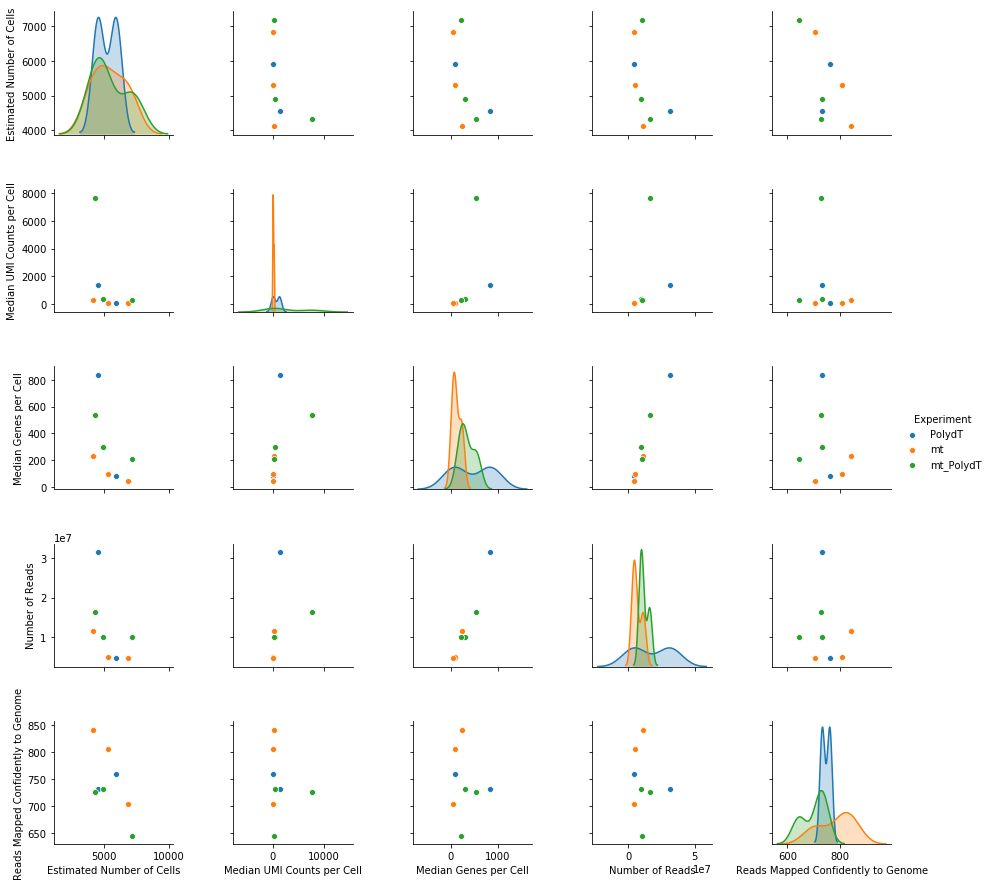

In [157]:
%matplotlib inline
sns.pairplot(samples,hue="Experiment",vars=["Estimated Number of Cells", 
                                           'Median UMI Counts per Cell',
                                           "Median Genes per Cell", 
                                           "Number of Reads", 
                                           "Reads Mapped Confidently to Genome"])
    

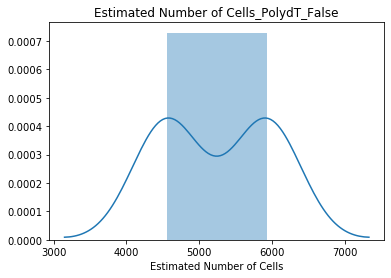

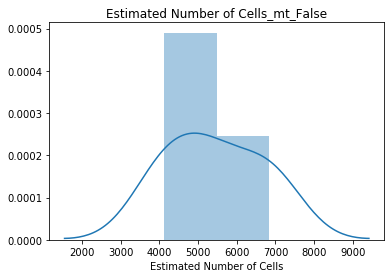

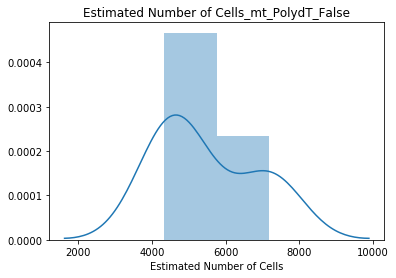

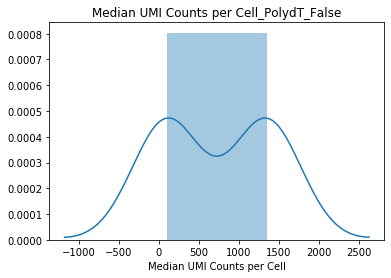

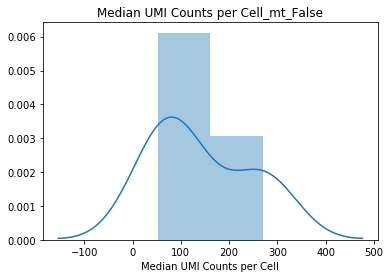

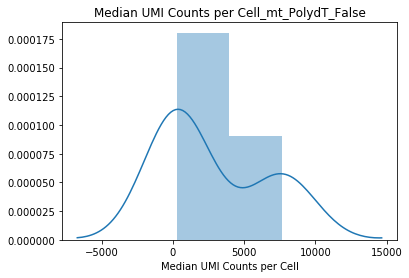

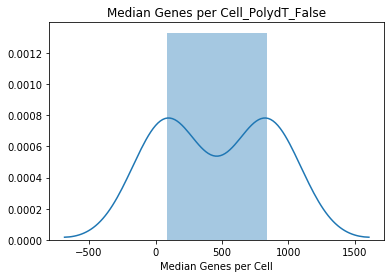

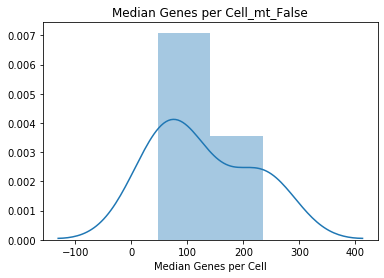

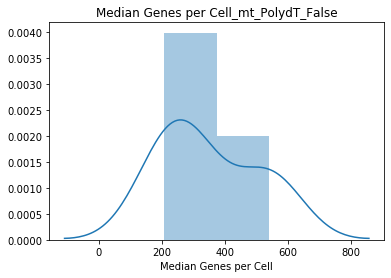

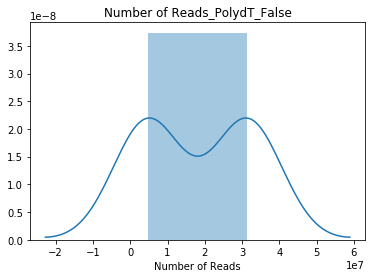

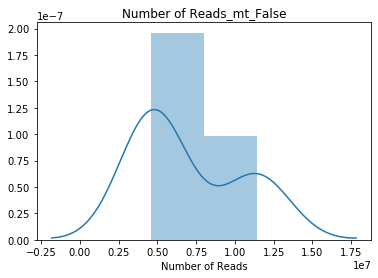

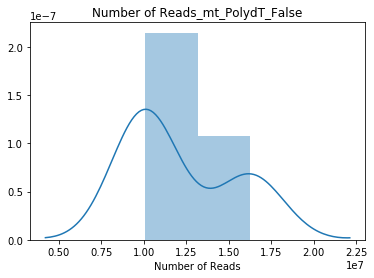

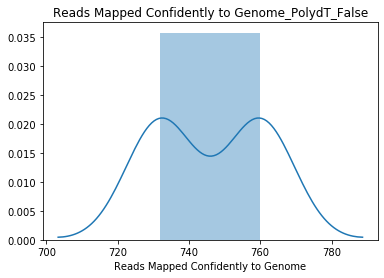

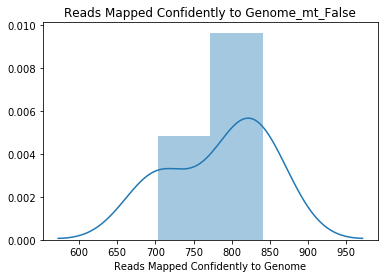

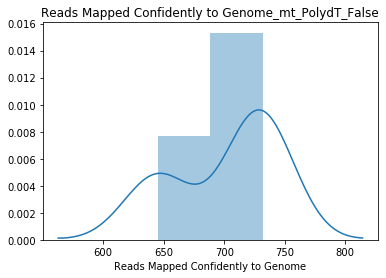

In [169]:

for c in ["Estimated Number of Cells", 
          'Median UMI Counts per Cell',
          "Median Genes per Cell", 
          "Number of Reads", 
          "Reads Mapped Confidently to Genome"]:
   
    for e in samples["Experiment"].unique():
        #for l in samples["Ligand"].unique():
        curr = samples[samples["Experiment"]==e]
        #curr = curr[curr["Ligand"] == l]
        f = plt.figure()
        sns.distplot(curr[c])
        plt.title(c+"_"+e+"_" + str(l))